In [2]:
import pandas as pd
import numpy as np
from keras.applications import VGG16
from keras.layers import Conv2D
from keras.models import Model
import pathlib
import os
from xml.etree import ElementTree as ET
import cv2
import matplotlib.pyplot as plt

2024-09-12 21:50:13.336488: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 21:50:13.494302: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-12 21:50:13.640129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 21:50:13.760255: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 21:50:13.794354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 21:50:14.019261: I tensorflow/core/platform/cpu_feature_gu

In [3]:
def anchor_boxes(image_size,grids_size,aspect_ratios):

    image_width, image_height, _ = image_size

    grid_width = image_width//grids_size[0]
    grid_height = image_height//grids_size[1]

    grid_center_x_start = grid_width//2
    grid_center_x_end = (grids_size[0] - 0.5)*grid_width 

    grid_center_x = np.linspace(grid_center_x_start,grid_center_x_end,grids_size[0])

    grid_center_y_start = grid_height//2
    grid_center_y_end = (grids_size[1] - 0.5)*grid_height

    grid_center_y = np.linspace(grid_center_y_start,grid_center_y_end,grids_size[1])

    grid_center_x_mesh, grid_center_y_mesh = np.meshgrid(grid_center_x,grid_center_y)

    grid_center_x_mesh = np.expand_dims(grid_center_x_mesh,-1)
    grid_center_y_mesh = np.expand_dims(grid_center_y_mesh,-1)

    anchor_boxes_no = len(aspect_ratios)

    anchor_boxes_tensor = np.zeros((grids_size[0],grids_size[1],anchor_boxes_no,4))

    anchor_boxes_tensor[...,0] = np.tile(grid_center_x_mesh,(1,1,anchor_boxes_no))
    anchor_boxes_tensor[...,1] = np.tile(grid_center_y_mesh,(1,1,anchor_boxes_no))

    anchor_box_width_height = list()

    for aspect_ratio in aspect_ratios:

        anchor_box_width_height.append((grid_width*np.sqrt(aspect_ratio),
                                        grid_height/np.sqrt(aspect_ratio)))
        
    anchor_box_width_height = np.array(anchor_box_width_height)

    anchor_boxes_tensor[...,2] = anchor_box_width_height[:,0]
    anchor_boxes_tensor[...,3] = anchor_box_width_height[:,1]

    return anchor_boxes_tensor

In [4]:
def centroid2minmax(anchor_boxes_centroid_tensor):

    anchor_boxes_minmax_tensor = np.copy(anchor_boxes_centroid_tensor)

    anchor_boxes_minmax_tensor[...,0] = anchor_boxes_minmax_tensor[...,0] - (anchor_boxes_minmax_tensor[...,2]//2)
    anchor_boxes_minmax_tensor[...,1] = anchor_boxes_minmax_tensor[...,1] - (anchor_boxes_minmax_tensor[...,3]//2)
    anchor_boxes_minmax_tensor[...,2] = anchor_boxes_minmax_tensor[...,0] + (anchor_boxes_minmax_tensor[...,2]//2)
    anchor_boxes_minmax_tensor[...,3] = anchor_boxes_minmax_tensor[...,1] + (anchor_boxes_minmax_tensor[...,3]//2)

    return anchor_boxes_minmax_tensor

In [5]:
def compute_IoU(anchor_boxes_tensor,image_gt_bbox_coords):

    image_gt_bbox_coords = np.array(image_gt_bbox_coords)
    IoU_tensor = np.zeros((len(image_gt_bbox_coords),anchor_boxes_tensor.shape[0],anchor_boxes_tensor.shape[1],anchor_boxes_tensor.shape[2]))
    anchor_boxes_minmax_tensor = centroid2minmax(anchor_boxes_tensor)

    gt_bboxes_mask = np.zeros((len(image_gt_bbox_coords),anchor_boxes_tensor.shape[0],anchor_boxes_tensor.shape[1],anchor_boxes_tensor.shape[2]))

    for i in range(len(image_gt_bbox_coords)):

        centroid_x_condition = (anchor_boxes_minmax_tensor[:,:,0,0]<(image_gt_bbox_coords[i,0]+image_gt_bbox_coords[i,2]//2)) & (anchor_boxes_minmax_tensor[:,:,0,2]>(image_gt_bbox_coords[i,0]+image_gt_bbox_coords[i,2]//2))
        centroid_y_condition = (anchor_boxes_minmax_tensor[:,:,0,1]<(image_gt_bbox_coords[i,1]+image_gt_bbox_coords[i,3]//2)) & (anchor_boxes_minmax_tensor[:,:,0,3]>(image_gt_bbox_coords[i,1]+image_gt_bbox_coords[i,3]//2))

        idxes = np.argwhere((centroid_x_condition & centroid_y_condition))

        gt_bboxes_mask[i,idxes,:] = 1.0

        for j in range(anchor_boxes_tensor.shape[2]):

            xmin_intersection = np.maximum(image_gt_bbox_coords[i][0],anchor_boxes_minmax_tensor[:,:,j,0])
            ymin_intersection = np.maximum(image_gt_bbox_coords[i][1],anchor_boxes_minmax_tensor[:,:,j,1])

            xmax_intersection = np.minimum(image_gt_bbox_coords[i][0]+image_gt_bbox_coords[i][2],anchor_boxes_minmax_tensor[:,:,j,2])
            ymax_intersection = np.minimum(image_gt_bbox_coords[i][1]+image_gt_bbox_coords[i][3],anchor_boxes_minmax_tensor[:,:,j,3])

            intersection_width = np.maximum(0,(xmax_intersection - xmin_intersection))
            intersection_height = np.maximum(0,(ymax_intersection - ymin_intersection))

            intersection_area = intersection_width * intersection_height

            image_gt_bbox_area = image_gt_bbox_coords[i][2] * image_gt_bbox_coords[i][3]
            anchor_boxes_width = (anchor_boxes_minmax_tensor[:,:,j,2] - anchor_boxes_minmax_tensor[:,:,j,0])
            anchor_boxes_height = (anchor_boxes_minmax_tensor[:,:,j,3] - anchor_boxes_minmax_tensor[:,:,j,1])

            union_area = ((anchor_boxes_width * anchor_boxes_height) + image_gt_bbox_area) - intersection_area

            IoU_tensor[i,:,:,j] = intersection_area/union_area

    return gt_bboxes_mask, IoU_tensor

In [23]:
def normalize_bbox_coords(image_size, image_gt_bbox_coords, gt_bboxes_mask, anchor_boxes_tensor):

    image_width, image_height, _ = image_size
    normalized_image_gt_bbox_coords = np.zeros_like(anchor_boxes_tensor)
    
    for i in range(len(image_gt_bbox_coords)):

        idx = np.argwhere((gt_bboxes_mask[i,:,:,0] == 1.0) | (gt_bboxes_mask[i,:,:,1] == 1.0))
        print(idx)
        normalized_image_gt_bbox_coords[idx,:,0] = (image_gt_bbox_coords[i][0] + (image_gt_bbox_coords[i][2]//2))/(image_gt_bbox_coords[i][0] + image_gt_bbox_coords[i][2])
        normalized_image_gt_bbox_coords[idx,:,1] = (image_gt_bbox_coords[i][1] + (image_gt_bbox_coords[i][3]//2))/(image_gt_bbox_coords[i][1] + image_gt_bbox_coords[i][3])
        normalized_image_gt_bbox_coords[idx,:,2] = image_gt_bbox_coords[i][2]//image_width
        normalized_image_gt_bbox_coords[idx,:,3] = image_gt_bbox_coords[i][3]//image_height

    return normalized_image_gt_bbox_coords

In [7]:
def create_gt_labels_tensor(normalized_image_gt_bbox_coords, IoU_tensor, gt_bboxes_mask, image_cls_labels, num_classes):

    cls_probabilities_tensor = np.zeros((normalized_image_gt_bbox_coords.shape[0],normalized_image_gt_bbox_coords.shape[1],num_classes))

    for i in range(gt_bboxes_mask.shape[0]):

        idx = np.argwhere((gt_bboxes_mask[i,:,:,0] == 1.0) | (gt_bboxes_mask[i,:,:,1] == 1.0))
        cls_probabilities_tensor[idx,:] = np.eye(num_classes,num_classes)[image_cls_labels[i]]

    gt_labels_tensor = np.copy(normalized_image_gt_bbox_coords)
    #The below three statements to compute the confidence scores assumes that
    #there is single object present in a Grid Cell which may not be the case.
    confidence_scores = IoU_tensor * gt_bboxes_mask
    final_confidence_scores = np.sum(confidence_scores,axis=0)
    final_confidence_scores = np.expand_dims(final_confidence_scores,-1)
    gt_labels_tensor = np.concatenate((gt_labels_tensor,final_confidence_scores),axis=3)
    gt_labels_tensor = gt_labels_tensor.reshape(gt_labels_tensor.shape[0],gt_labels_tensor.shape[1],gt_labels_tensor.shape[2]*gt_labels_tensor.shape[3])

    gt_labels_tensor = np.concatenate((gt_labels_tensor,cls_probabilities_tensor),axis=2)
    
    return gt_labels_tensor

In [8]:
def object_detection_cnn():

    vgg16 = VGG16(include_top=False,input_shape=(640,480,3),weights="imagenet",pooling=None)
    vgg16.trainable = False
    input_to_vgg16 = vgg16.input
    vgg16_output = Conv2D(filters=30,kernel_size=(14,9))(vgg16.layers[-1].output)

    return Model(inputs=[input_to_vgg16],outputs=[vgg16_output])

In [9]:
yolov1_cnn = object_detection_cnn()

In [10]:
yolov1_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 640, 480, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 640, 480, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 640, 480, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 320, 240, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 320, 240, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 320, 240, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 160, 120, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 160, 120, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 160, 120, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 160, 120, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 80, 60, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 80, 60, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 80, 60, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 80, 60, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 40, 30, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 40, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 40, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 40, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 20, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 30)       │     1,935,390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,650,078 (63.52 MB)

 Trainable params: 1,935,390 (7.38 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [11]:
def train_test_df(imgs_base_path,annotations_base_path):

    img_complete_paths = list()
    img_class_labels = list()
    img_gt_bbox_coords = list()

    for single_img_complete_path in pathlib.Path(imgs_base_path).glob("*"):

        img_path = str(single_img_complete_path)
        img_label_path = os.path.join(annotations_base_path,str(single_img_complete_path).split("/")[-1].split(".")[0]+".xml")

        class_gt_labels_list = list()
        gt_bbox_coords_list = list()

        tree = ET.parse(img_label_path)
        root = tree.getroot()

        for member in root.findall("object"):
            """
            for child in member:

                if child.tag == "name":
                    class_gt_labels_list.append(child.text)

                if child.tag == "bndbox":
                    xmin = float(child[0].text)
                    ymin = float(child[1].text)
                    xmax = float(child[2].text)
                    ymax = float(child[3].text)
            """
            class_gt_labels_list.append(member.find("name").text)
            xmin = float(member.find("bndbox/xmin").text)
            ymin = float(member.find("bndbox/ymin").text)
            xmax = float(member.find("bndbox/xmax").text)
            ymax = float(member.find("bndbox/ymax").text)
            
            bbox_width = xmax - xmin
            bbox_height = ymax - ymin
            

            gt_bbox_coords_list.append([xmin,ymin,bbox_width,bbox_height])

        img_complete_paths.append(str(single_img_complete_path))
        img_class_labels.append(class_gt_labels_list)
        img_gt_bbox_coords.append(gt_bbox_coords_list)

    return pd.DataFrame(data={"img_path":img_complete_paths,
                              "img_gt_class_labels":img_class_labels,
                              "img_gt_bbox_coords":img_gt_bbox_coords})

In [12]:
data_df = train_test_df("VOCdevkit/VOC2012/JPEGImages","VOCdevkit/VOC2012/Annotations")

In [13]:
data_df

,img_path,img_gt_class_labels,img_gt_bbox_coords
0,VOCdevkit/VOC2012/JPEGImages/2009_001091.jpg,"[bus, person, person, person, person, person, ...","[[1.0, 1.0, 253.0, 250.0], [1.0, 128.0, 73.0, ..."
1,VOCdevkit/VOC2012/JPEGImages/2011_003495.jpg,"[person, person]","[[208.0, 3.0, 65.0, 71.0], [105.0, 30.0, 89.0,..."
2,VOCdevkit/VOC2012/JPEGImages/2011_002826.jpg,"[bus, bus, bus, bus]","[[355.0, 109.0, 49.0, 69.0], [435.0, 117.0, 64..."
3,VOCdevkit/VOC2012/JPEGImages/2012_001976.jpg,[person],"[[159.0, 154.0, 139.0, 346.0]]"
4,VOCdevkit/VOC2012/JPEGImages/2009_003232.jpg,[horse],"[[61.0, 88.0, 258.0, 272.0]]"
...,...,...,...
17120,VOCdevkit/VOC2012/JPEGImages/2009_000165.jpg,"[car, person]","[[139.0, 139.0, 123.0, 79.0], [483.0, 103.0, 1..."
17121,VOCdevkit/VOC2012/JPEGImages/2007_007196.jpg,"[tvmonitor, tvmonitor, tvmonitor]","[[338.0, 55.0, 162.0, 185.0], [171.0, 57.0, 16..."
17122,VOCdevkit/VOC2012/JPEGImages/2011_007171.jpg,"[person, person]","[[170.0, 82.0, 144.0, 399.0], [20.0, 206.0, 11..."
17123,VOCdevkit/VOC2012/JPEGImages/2011_005124.jpg,"[person, person]","[[78.0, 253.0, 76.0, 157.0], [169.0, 251.0, 54..."


In [14]:
training_data = data_df.iloc[0:15000,:]
cv_data = data_df.iloc[15000:,]

"""
training_data.to_csv("./training_data.csv",index=False,float_format=None)
cv_data.to_csv("./cv_data.csv",index=False,float_format=None)
"""

'\ntraining_data.to_csv("./training_data.csv",index=False,float_format=None)\ncv_data.to_csv("./cv_data.csv",index=False,float_format=None)\n'

In [28]:
#training_data = pd.read_csv("training_data.csv")

In [15]:
training_data

,img_path,img_gt_class_labels,img_gt_bbox_coords
0,VOCdevkit/VOC2012/JPEGImages/2009_001091.jpg,"[bus, person, person, person, person, person, ...","[[1.0, 1.0, 253.0, 250.0], [1.0, 128.0, 73.0, ..."
1,VOCdevkit/VOC2012/JPEGImages/2011_003495.jpg,"[person, person]","[[208.0, 3.0, 65.0, 71.0], [105.0, 30.0, 89.0,..."
2,VOCdevkit/VOC2012/JPEGImages/2011_002826.jpg,"[bus, bus, bus, bus]","[[355.0, 109.0, 49.0, 69.0], [435.0, 117.0, 64..."
3,VOCdevkit/VOC2012/JPEGImages/2012_001976.jpg,[person],"[[159.0, 154.0, 139.0, 346.0]]"
4,VOCdevkit/VOC2012/JPEGImages/2009_003232.jpg,[horse],"[[61.0, 88.0, 258.0, 272.0]]"
...,...,...,...
14995,VOCdevkit/VOC2012/JPEGImages/2008_005975.jpg,"[diningtable, chair, chair, chair]","[[1.0, 102.0, 499.0, 273.0], [65.0, 293.0, 349..."
14996,VOCdevkit/VOC2012/JPEGImages/2010_005806.jpg,[cat],"[[2.0, 99.0, 298.0, 338.0]]"
14997,VOCdevkit/VOC2012/JPEGImages/2010_005775.jpg,"[dog, chair]","[[170.0, 138.0, 169.0, 133.0], [1.0, 84.0, 178..."
14998,VOCdevkit/VOC2012/JPEGImages/2008_002775.jpg,"[bottle, person, diningtable]","[[96.0, 162.0, 92.0, 213.0], [104.0, 16.0, 155..."


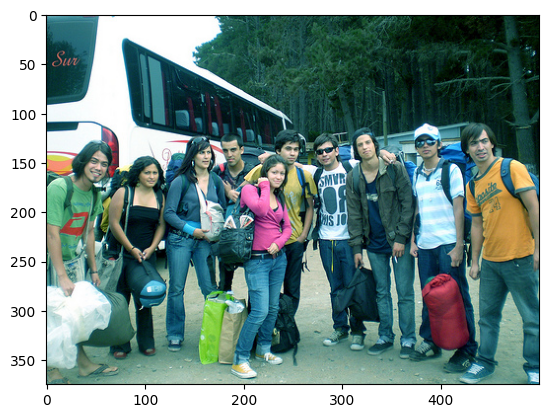

In [16]:
plt.imshow(plt.imread(training_data.iloc[0,0]))

In [17]:
training_data.iloc[0,1]

['bus',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person']

In [18]:
training_data.iloc[0,2]

[[1.0, 1.0, 253.0, 250.0],
 [1.0, 128.0, 73.0, 247.0],
 [63.0, 146.0, 63.0, 204.0],
 [120.0, 126.0, 65.0, 218.0],
 [171.0, 122.0, 50.0, 161.0],
 [189.0, 143.0, 62.0, 226.0],
 [188.0, 120.0, 92.0, 186.0],
 [217.0, 123.0, 138.0, 221.0],
 [305.0, 117.0, 73.0, 235.0],
 [370.0, 112.0, 70.0, 251.0],
 [420.0, 113.0, 80.0, 262.0]]

In [22]:
def custom_data_generator(df,mb_size):

    for i in range(df.shape[0]//mb_size):

        X_train_mb = list()
        Y_train_mb = list()

        for j in range(0,mb_size):

            df_mb = df.iloc[(i*mb_size)+j]
            img_path = df_mb["img_path"]

            X_train_mb.append(cv2.resize(plt.imread(img_path),(480,640)))

            gt_bboxes_mask, iou_tensor = compute_IoU(anchor_boxes_tensor,df_mb["img_gt_bbox_coords"])
            normalized_img_gt_bbox_coords = normalize_bbox_coords((640,480,3),df_mb["img_gt_bbox_coords"],
                                                                  gt_bboxes_mask,anchor_boxes_tensor)
            Y_train_mb.append(create_gt_labels_tensor(normalized_img_gt_bbox_coords,iou_tensor,gt_bboxes_mask,
                                                      df_mb["img_gt_class_labels"],20))
            
        yield X_train_mb, Y_train_mb